# Subsample master light curves 

* subsample using np.interp1d from `dp2/sim_master`   using real cadences of combined SDSS,PS1 light curves.
or simulated cadences of LSST and ZTF
* add the median of each real light curve 
* add photometric noise corresponding to real light curves (SDSS,PS1), or simulated magnitude-dependent error curves (LSST, ZTF)
* store in `dp2/sim_subsampled/`

In [93]:
import numpy as np
import matplotlib.pyplot as plt 
import os
import pandas as pd 
from astropy.table import Table
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import  hstack
from astropy.table import  vstack
from astropy.table import unique
from astropy.table import Column
from astropy.table import join
import celerite
from matplotlib import rcParams 
import imp
mod = imp.load_source('modules.py', '../code/modules.py')

rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

[TLDR : make error curve](#error)

[Plot combined LC with underlying simulated DRW signal](#plot_combined)

[Plot combined LC with DRW signal and Celerite fit](#plot_combined_fit)

In [86]:
def calc_lsst_error(m, gamma=0.039 , sigma_sys=0.005, m5=24.7):
    # Calculate LSST error based on the magnitude of the observed light curve ...
    # we use magnitude-dependent single-visit 
    # formula for r-band from 
    # https://www.lsst.org/sites/default/files/docs/sciencebook/SB_3.pdf
    # https://www.lsst.org/scientists/scibook
    # https://arxiv.org/abs/0912.0201
    # See Chap.3, Sec. 3.5, Eq. 3.1, Table. 3.2
     # mag 
    #sigma_sys = 0.005
    #gamma = 0.039 
    #m5 = 24.7
    x = np.power(10,0.4 * (m-m5))
    sigma_rand = np.sqrt(  (0.04-gamma) * x + gamma * x*x ) 
    sigma = np.sqrt(sigma_sys**2.0 + sigma_rand**2.0)
    return sigma

# Note : for LSST, use gamma=0.039 , sigma_sys=0.005, m5=24.7
# and for ZTF, use gamma=0.025, sigma_sys = 0.005, m5 = 20.8
# ( based on the plot of best median mag vs best mag rms in g-band )

   Note : after the new `Crossmatch_...` and `Combine_all....` , it would be better to use as realDir  `../dp2/real_combined_r/`

In [87]:
# combined light curves
realDir = '../data_products/Combined_LC/'
realLcs =  os.listdir(realDir)


t_sim  = np.loadtxt('../dp2/t_master.txt')
mjd_lsst = np.loadtxt('../dp2/mjd_lsst_ten_years_500_epochs.txt')
mjd_ztf = np.loadtxt('../dp2/mjd_ztf_2018_240_epochs.txt')

for i in range(len(realLcs)):
    if (i % 1000) == 0 : 
        print(i)
    # Load the i-th master light curve
    simDir = '../dp2/sim_master/'
    y_sim = np.loadtxt(simDir+str(i).zfill(4)+'.txt')

    lc_sim = Table([y_sim, t_sim], names=['mag_true', 'mjd'])

    # Load the i-th combined real light curve 
    lcname = realLcs[i]
    lc_comb = Table.read(realDir+lcname, format='ascii')
    lc_comb.sort('mjd') # sort by mjd .... 
    # keep only the first row if there are two rows that for 
    # some reason have the same MJD ...
    lc_comb = unique(lc_comb, keys='mjd', keep='first')
    
    # keep survey information 
    survey = np.append(np.asarray(lc_comb['originSurvey']), 
             np.repeat('ztf',len(mjd_ztf)))
    survey = np.append(survey, np.repeat('lsst', len(mjd_lsst)))

    # add info on band of origin 
    band = np.append(np.asarray(lc_comb['originBand']), 
                     np.repeat('r', len(mjd_ztf)))
    band = np.append(band, np.repeat('r', len(mjd_lsst)))


    # add simulated ZTF and LSST cadence 
    mjd_comb = np.append(np.asarray(lc_comb['mjd']),  mjd_ztf)
    mjd_comb = np.append(mjd_comb, mjd_lsst)


    # subsample at the SDSS-PS1-PTF-CRTS-ZTF-LSST combined 
    # cadences -  sample at those times using  np.interp1d 
    y_true = np.interp(mjd_comb, lc_sim['mjd'], lc_sim['mag_true'])

    # add the median magnitude of the combined light curve to these sampled points
    y_true += np.mean(lc_comb['mag']) 

    # simulate ZTF and LSST errors given the magnitudes at these times
    #ztf_error = 1.5* calc_lsst_error(y_true[survey =='ztf'])
    ztf_error = calc_lsst_error(y_true[survey =='ztf'],
                                gamma=0.025, sigma_sys = 0.005, m5 = 20.8)
    # note : 
    lsst_error = calc_lsst_error(y_true[survey =='lsst'])

    y_err = np.append(np.asarray(lc_comb['magerr']),ztf_error)
    y_err = np.append(y_err, lsst_error)

    # add the photometric noise corresponding to epochal errors 
    y_obs = y_true +  y_err * np.random.normal(loc=0,scale=1,size=len(y_true))

    # store as sim_subsample/  , saving as : 
    # mjd   |  mag_true   |  mag_obs    | error   |   survey    

    lc_obs = Table([mjd_comb, y_true, y_obs, y_err, band, survey], 
                      names=['mjd','magtrue', 'magobs', 'magerr',
                             'originBand', 'originSurvey'])
    obsDir = '../dp2/sim_subsampled2/'
    lc_obs.write(obsDir+lcname, format='ascii', overwrite=True)

0
1000
2000
3000
4000
5000
6000


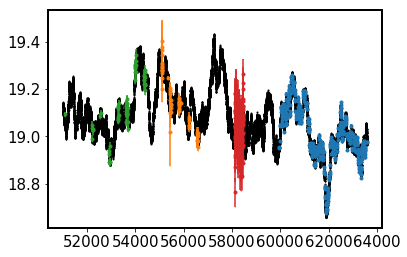

In [89]:
# this illustrates which parts of simulated light curve are 
# 'observed'  at real cadences ...
%matplotlib inline
plt.scatter(lc_sim['mjd'], lc_sim['mag_true']+np.mean(lc_comb['mag']) , c='k',
           s=1)
for s in ['lsst', 'ps1',  'sdss', 'ztf']:
    m = survey == s
    plt.errorbar(mjd_comb[m], y_obs[m], y_err[m], fmt=".", capsize=0.2,)
#plt.xlim(52000,53000)

## Plot combined light curve ... <a id='plot_combined'></a>

Text(0.5, 0, 'Time [mjd]')

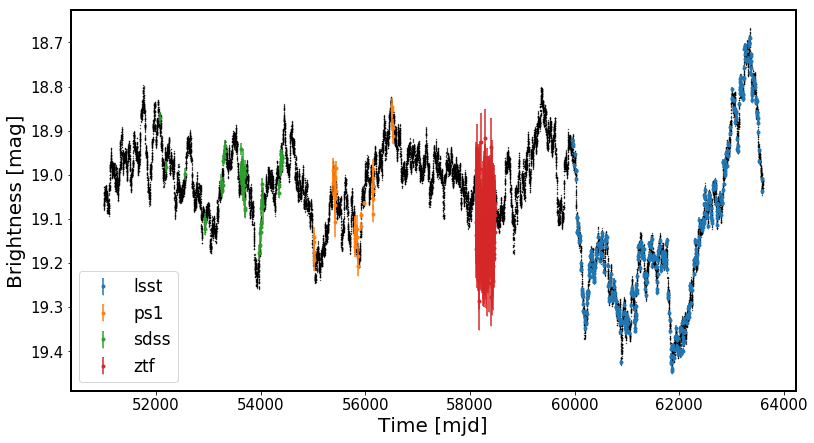

In [70]:
%matplotlib inline
# plot the true signal,  and the subsampling , to show what is being saved...
t_sim  = np.loadtxt('../dp2/t_master.txt')
realDir = '../data_products/Combined_LC/'
realLcs =  os.listdir(realDir)

i = 8
# Load the i-th master light curve
simDir = '../dp2/sim_master/'
y_sim = np.loadtxt(simDir+str(i).zfill(4)+'.txt')

# all simulated light curves were centered around 0...
# the observed ones were subsampling at desired cadences,
# and adding the mean magnitude of the combined real light curve ... 
# and then adding the Gaussian noise

# so it's definitely underlying DRW,

# I think the better approach in the future may well be 
# to simulate each DRW around the mean of the combined light curve,
# and then subsample and add Gaussian noise. 

lc_sim = Table([y_sim, t_sim], names=['mag_true', 'mjd'])

# load the i-the subsampled master light curve 
obsDir = '../dp2/sim_subsampled2/'
lcname = realLcs[i]
lc_obs = Table.read(obsDir+lcname, format='ascii',)


# load the i-th real combined light curve 
lc_comb = Table.read(realDir+lcname, format='ascii')
lc_comb.sort('mjd') # sort by mjd .... 
# keep only the first row if there are two rows that for 
# some reason have the same MJD ...
lc_comb = unique(lc_comb, keys='mjd', keep='first')


# plotting ... 
fig,ax = plt.subplots(1,1,figsize=(13,7))

# plot the real underlying DRW signal ...
#ax.scatter(lc_sim['mjd'], lc_sim['mag_true']+np.mean(lc_obs['magobs']), s=0.1, c='k',
#           label='')


# plot the observed signal 
for s in ['lsst', 'ps1','sdss','ztf',]:#['lsst', 'ps1',  'sdss', 'ztf',  'ptf']:
    m = lc_obs['originSurvey'] == s
    # plot the "observed" lc 
    ax.errorbar(lc_obs['mjd'][m], lc_obs['magobs'][m], 
                 lc_obs['magerr'][m], fmt=".", capsize=0.2, label=s)
    
    # plot the underlying "true" signal ... 
    #ax.scatter(lc_obs['mjd'][m], lc_obs['magtrue'][m], s=1, c='k',
    #      label='')
    
# plot the master signal, before sampling ... 
# adding the mean of the combined light  curve, 
# just like they were made (above )

ax.scatter(lc_sim['mjd'], lc_sim['mag_true']+np.mean(lc_comb['mag']), s=0.1, c='k',
         label='')
#ax.scatter(lc_sim['mjd'], lc_sim['mag_true']+np.mean(lc_obs['magobs']), s=0.1, c='k',
#           label='')

ax.legend(loc='lower left', fontsize=17)
ax.invert_yaxis()
ax.set_ylabel('Brightness [mag]')
ax.set_xlabel('Time [mjd]')
#ax.set_xlim(53600,53800)
#plt.savefig('Simulated_DRW-'+str(i).zfill(4)+'_sampled-'+\
#           lcname[:-4]+'.png', bbox_inches='tight')

Illustration of subsampling the true DRW signal (black), at cadences corresponding to a combined light curve. The original DRW signal is modeled with mean around 0, so the offset equal to the mean of the combined light curve is added.  At each sampled epoch, a photometric Gaussian noise is added, with variance representing the uncertainty of epochal measurement. For ZTF and LSST simulated cadence, error is modeled after the simulated brightness (magnitude-dependent error model). 

## Plot combined light curve with Celerite fit ... <a id='plot_combined_fit'></a>

Plot the **Celerite** fit to the SDSS-PS1-CRTS-PTF-LSST part ... This also illustrates the point that ZTF, PTF , CRTS errors are wy larger than PS1, SDSS, or LSST 

[-3.21887582 -4.60517019]
sig_lims: [0.01, 1] tau_lims: [1, 10000]
[(-9.210340371976182, 0.0), (-9.210340371976182, 0.0)]
sigma_fit 0.1466797464028313 tau_fit 609.5844458600562


Saved as   Simulated_DRW-0008_sampled-3537034_fit.png


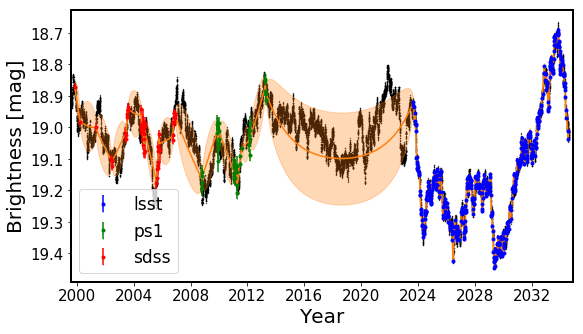

In [110]:

%matplotlib inline
# plot the true signal,  and the subsampling , to show what is being saved...
t_sim  = np.loadtxt('../dp2/t_master.txt')
realDir = '../data_products/Combined_LC/'
realLcs =  os.listdir(realDir)

i = 8
# Load the i-th master light curve
simDir = '../dp2/sim_master/'
y_sim = np.loadtxt(simDir+str(i).zfill(4)+'.txt')

# all simulated light curves were centered around 0...
# the observed ones were subsampling at desired cadences,
# and adding the mean magnitude of the combined real light curve ... 
# and then adding the Gaussian noise

# so it's definitely underlying DRW,

# I think the better approach in the future may well be 
# to simulate each DRW around the mean of the combined light curve,
# and then subsample and add Gaussian noise. 

lc_sim = Table([y_sim, t_sim], names=['mag_true', 'mjd'])

# load the i-the subsampled master light curve 
obsDir = '../dp2/sim_subsampled2/'
lcname = realLcs[i]
lc_obs = Table.read(obsDir+lcname, format='ascii',)


# load the i-th real combined light curve 
lc_comb = Table.read(realDir+lcname, format='ascii')
lc_comb.sort('mjd') # sort by mjd .... 
# keep only the first row if there are two rows that for 
# some reason have the same MJD ...
lc_comb = unique(lc_comb, keys='mjd', keep='first')


# plotting ... 
fig,ax = plt.subplots(1,1,figsize=(9,5))

# plot the observed signal 
use_segments = 'lsst,ps1,sdss'
colors = ['blue','green','red']
j = 0
for s in use_segments.split(','):#['lsst', 'ps1',  'sdss', 'ztf',  'ptf']:
    m = lc_obs['originSurvey'] == s
    # plot the "observed" lc 
    ax.errorbar(lc_obs['mjd'][m], lc_obs['magobs'][m], 
                 lc_obs['magerr'][m], fmt=".", capsize=0.2, label=s,
               c = colors[j])
    j += 1 
    
    # plot the underlying "true" signal ... 
    #ax.scatter(lc_obs['mjd'][m], lc_obs['magtrue'][m], s=1, c='k',
    #      label='')
    
# plot the master signal, before sampling ... 
# adding the mean of the combined light  curve, 
# just like they were made (above )
ax.scatter(lc_sim['mjd'], lc_sim['mag_true']+np.mean(lc_comb['mag']), s=0.1, c='k',
         label='')  
#ax.set_xlim(53600,53800)
#

# fit to the observed simulation, using desired segments...
m = np.in1d(lc_obs['originSurvey'], use_segments.split(','))
tz = lc_obs['mjd'][m].data
yz = lc_obs['magobs'][m].data 
ez = lc_obs['magerr'][m].data
sigma0 = 0.2
tau0 = 100 
prior='Jeff1'
sig_lims = [0.01,1]
tau_lims = [1,10000]

sigmaMAP, tauMAP,gp = mod.find_celerite_MAP(tz,yz,ez, 
                          sigma0, tau0, prior=prior,set_bounds=True, 
                          sig_lims=sig_lims, tau_lims=tau_lims ,verbose=True)
# plot the prediction conditioned on the observed data 
x = np.linspace(min(tz), max(tz), 5000)
pred_mean, pred_var = gp.predict(yz, x, return_var=True)
pred_std = np.sqrt(pred_var)
color = "#ff7f0e"
ax.plot(x, pred_mean, color=color)
ax.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, 
                 color=color, alpha=0.3,
                 )
import matplotlib.dates as mdates
# plot setup 
ax.legend(loc='lower left', fontsize=17)
ax.invert_yaxis()
ax.set_ylabel('Brightness [mag]')
#ax.set_xlabel('Time [mjd]')
ax.set_xlim(min(lc_obs['mjd'])-100, max(lc_obs['mjd'])+100)

# turn off the ticks on the original x-axis 
ax.set_xticks([])


# make another axis to show years ... 
ax2 = ax.twiny()

# Move twinned axis ticks and label from top to bottom
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")

# Move the twin axisto the location of the old axis 
# (eg. -0.25 would be below the old x-axis)
ax2.spines["bottom"].set_position(("axes",0 ))

# Turn on the frame for the twin axis, but then hide all 
# but the bottom spine
ax2.set_frame_on(True)
ax2.patch.set_visible(False)
ax2.spines["bottom"].set_visible(True)
# add the xlabel 
ax2.set_xlabel("Year")

# span an mjd space between the old limits of the x-axis ... 
mjd = np.linspace(xlims[0], xlims[1], 10)

# convert those to datetime .... 
t = Time(mjd, format='mjd')

# and plot , setting the ylimits to the old ylimits ... 
# we set markersize to 0, so that we don't see anything 
# ( it's like plotting with 'nodata' = True )
ax2.plot_date(t.datetime, np.zeros(len(t)), markersize=0)
ax2.set_ylim(ylims)

# format the xticks .... 
ax2.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')

figname = 'Simulated_DRW-'+str(i).zfill(4)+'_sampled-'+ \
            lcname[:-4]+'_fit.png'
plt.savefig(figname, bbox_inches='tight')
print('Saved as  ' , figname)

### Calcualate  the error distribution for simulated combined r-band light curves ... 

In [100]:
obsDir = '../dp2/sim_subsampled2/'
stats = {}
segs = ['lsst', 'ps1',  'sdss', 'ztf', 'ptf']
for s in segs: 
    stats[s] = {'lcname':[], 'medErr':[], 'meanErr':[], 'medMag':[] }
    
for i in range(len(realLcs)) : 
    lcname = realLcs[i]
    lc_obs = Table.read(obsDir+lcname, format='ascii',)
    for s in segs : 
        m = lc_obs['originSurvey'] == s
        lc = lc_obs[m]
        stats[s]['lcname'].append(lcname)
        stats[s]['medErr'].append(np.median(lc['magerr']))
        stats[s]['meanErr'].append(np.mean(lc['magerr']))
        stats[s]['medMag'].append(np.median(lc['magobs']))
    if i % 1000 == 0 : print(i)
fname = 'sim_subsampled2_stats'
np.save(fname, stats)

0


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


1000
2000
3000


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3115: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


4000
5000
6000


(the above took ~5 mins to run )

## Make median error plot <a id='error'></a> 

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


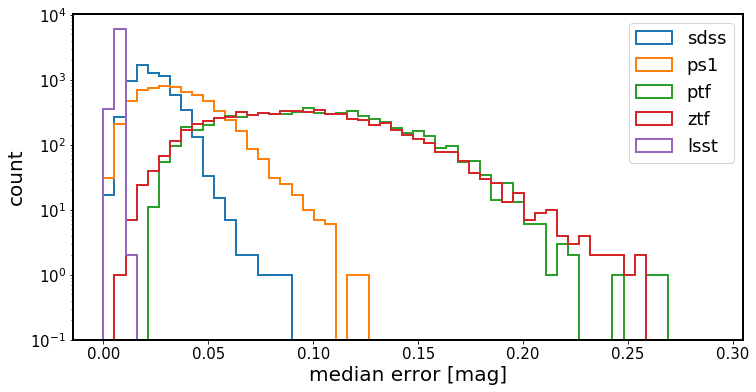

In [3]:
fname = 'sim_subsampled2_stats.npy'
r = np.load(fname).item()

%matplotlib inline
fig,ax = plt.subplots(1,1,figsize=(12,6))
for seg in ['sdss', 'ps1','ptf','ztf', 'lsst']:#list(r.keys()):
    #ax.hist(sall['medErr_'+seg], range = (0,0.5),lw=2, label=seg, bins=45,
    #       histtype='step')
    ax.hist(r[seg]['medErr'],lw=2, range = (0,0.29), label=seg, bins=55,
           histtype='step', density=False, log=True)
ax.legend(fontsize=18)
ax.set_xlabel('median error [mag]')
ax.set_ylabel('count')
plt.savefig('sim_subsampled2_stats_error_log.png', bbox_inches='tight')

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


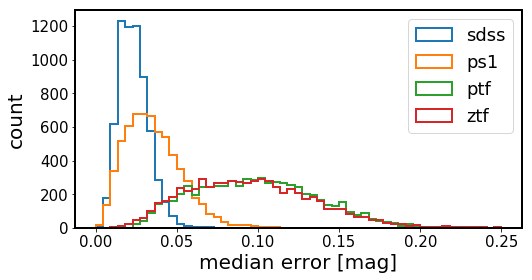

In [5]:
fname = 'sim_subsampled2_stats.npy'
r = np.load(fname).item()

%matplotlib inline
fig,ax = plt.subplots(1,1,figsize=(8,4))
for seg in ['sdss', 'ps1','ptf','ztf',]:#list(r.keys()):
    #ax.hist(sall['medErr_'+seg], range = (0,0.5),lw=2, label=seg, bins=45,
    #       histtype='step')
    ax.hist(r[seg]['medErr'],lw=2, range = (0,0.25), label=seg, bins=55,
           histtype='step', density=False, log=False)
ax.legend(fontsize=18)
ax.set_xlabel('median error [mag]')
ax.set_ylabel('count')
plt.savefig('sim_subsampled2_stats_error_lin.png', bbox_inches='tight', dpi=100)